## Set up environment

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
#import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [10]:
print(keras.__version__)
tf.__version__

2.0.8


'1.1.0'

In [11]:
# get a GPU session and reserve memory
def get_session(gpu_fraction=0.3):
    '''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''

    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session(.90))

In [12]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [13]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [14]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [15]:
np.random.seed(123)

# Vars and HPs

In [16]:
# Set hyper parameters
original_dim = 300000
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

# Load methylation data

In [18]:
methyl_file = os.path.join('data', 'test_data_top300kMAD_cpg.tsv')
methyl_df = pd.read_table(methyl_file, index_col=0)
print(methyl_df.shape)
methyl_df.head(5)

(16, 300000)


,cg12551908,cg04333867,cg13885788,cg14323910,cg03075889,cg26225655,cg11956442,cg22535849,cg23813394,cg11331837,...,cg22220165,cg26169020,cg10872774,cg18771653,cg01589779,cg17066932,cg25190094,cg26630048,cg25461934,cg27381930
GSM2861662,0.988919,0.002018,0.046356,0.961611,0.436784,0.002018,0.666119,0.963889,0.024831,0.044640,...,0.047487,0.041729,0.947007,0.042100,0.085965,0.953548,0.950439,0.935476,0.952554,0.947290
GSM2861663,0.023201,0.001931,0.966425,0.951948,0.407305,0.393815,0.705134,0.965805,0.975068,0.593630,...,0.025422,0.042099,0.937926,0.049064,0.075847,0.937341,0.953792,0.933287,0.957183,0.961461
GSM2861664,0.629825,0.002436,0.040250,0.959272,0.971169,0.397908,0.058336,0.961569,0.507234,0.028984,...,0.046685,0.048319,0.917903,0.053058,0.067478,0.958766,0.936375,0.947892,0.959456,0.937973
GSM2861665,0.037642,0.000332,0.036839,0.117744,0.036340,0.000332,0.989604,0.956448,0.965239,0.622758,...,0.021291,0.050028,0.954278,0.049335,0.073846,0.950377,0.945870,0.944687,0.974801,0.959850
GSM2861666,0.029749,0.942957,0.494914,0.898285,0.039637,0.000128,0.036056,0.959613,0.028459,0.573506,...,0.035635,0.052849,0.923411,0.062079,0.063555,0.919550,0.951887,0.916464,0.960741,0.947049


In [19]:
# Reduce the data size for model testing
methyl_df2 = methyl_df.sample(original_dim, axis=1) # this is not correct when real training happens
print(methyl_df2.shape)
methyl_df2.head(5)

(16, 300000)


,cg19242459,cg06365016,cg23548438,cg16339238,cg06160397,cg11075353,cg20785560,cg14040931,cg15233892,cg23184518,...,cg11519260,cg00691123,cg25254074,cg08904363,cg01385312,cg09251737,cg26335633,cg18940047,cg14855657,cg21722775
GSM2861662,0.940602,0.855804,0.344986,0.036378,0.882570,0.500409,0.302655,0.888828,0.138864,0.939979,...,0.928271,0.351497,0.757858,0.192191,0.907131,0.928538,0.113393,0.169197,0.075777,0.930340
GSM2861663,0.934186,0.958937,0.519697,0.152623,0.890004,0.020511,0.354201,0.832888,0.210407,0.905674,...,0.920533,0.496424,0.811230,0.125436,0.923287,0.861147,0.199454,0.361812,0.066014,0.892449
GSM2861664,0.933304,0.757727,0.327101,0.032106,0.849765,0.902973,0.202559,0.869846,0.100477,0.948471,...,0.957843,0.331091,0.791177,0.145568,0.920710,0.957216,0.106493,0.111420,0.060864,0.920947
GSM2861665,0.942844,0.832105,0.329067,0.022177,0.894589,0.937630,0.137104,0.853889,0.080377,0.968162,...,0.941672,0.355915,0.849760,0.068299,0.875309,0.950409,0.083378,0.085558,0.044870,0.923014
GSM2861666,0.930556,0.689961,0.488912,0.198177,0.833614,0.474122,0.250998,0.836049,0.243801,0.922548,...,0.934487,0.447678,0.688451,0.088590,0.920544,0.943395,0.327064,0.338972,0.088452,0.916144


In [20]:
# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df2.sample(frac=test_set_percent)
methyl_train_df = methyl_df2.drop(methyl_test_df.index)

# Encoder

In [21]:
# Input place holder for methylation data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
# and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the methyl input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# Decoder

In [22]:
# The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

# Encoder + Decoder = VAE

In [23]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300000)        0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           30000100    input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           30000100    input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 100)           400         dense_1[0][0]                    
___________________________________________________________________________________________

/Users/alexandertitus/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


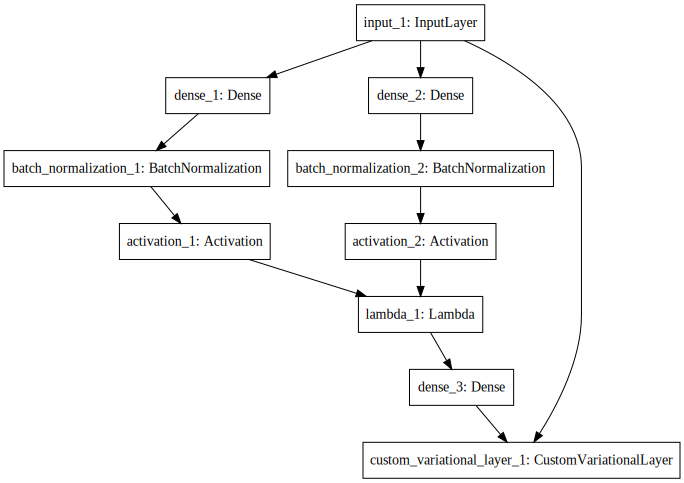

In [24]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'onehidden_vae_architecture.eps')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

# Train the model

In [26]:
%%time
hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               #validation_data=(np.array(methyl_test_df), np.array(methyl_test_df)),
               callbacks=[WarmUpCallback(beta, kappa)])

Epoch 1/50
14/14 [==============================] - 8s - loss: 207999.3906
Epoch 2/50
14/14 [==============================] - 4s - loss: 206567.6406
Epoch 3/50
14/14 [==============================] - 2s - loss: 204927.1406
Epoch 4/50
14/14 [==============================] - 2s - loss: 202323.0781
Epoch 5/50
14/14 [==============================] - 2s - loss: 201115.5000
Epoch 6/50
14/14 [==============================] - 3s - loss: 198864.0781
Epoch 7/50
14/14 [==============================] - 2s - loss: 198418.8594
Epoch 8/50
14/14 [==============================] - 2s - loss: 195372.7500
Epoch 9/50
14/14 [==============================] - 2s - loss: 194400.7812
Epoch 10/50
14/14 [==============================] - 2s - loss: 193515.0781
Epoch 11/50
14/14 [==============================] - 3s - loss: 190673.6406
Epoch 12/50
14/14 [==============================] - 2s - loss: 188994.2656
Epoch 13/50
14/14 [==============================] - 2s - loss: 189319.2656
Epoch 14/50
14/14 [==

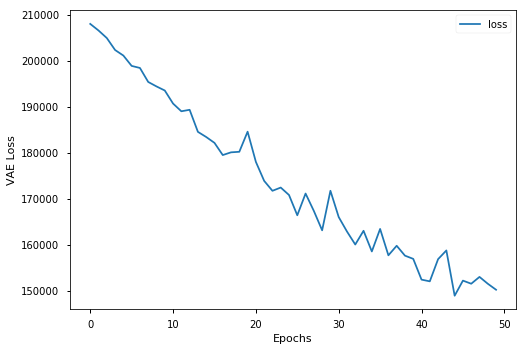

In [27]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training_300K-100.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_30K-1000.pdf') 
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-10.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_100K-100.pdf')
#hist_plot_file = os.path.join('figures', 'onehidden_vae_training_10K-100.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

# Compile and output models

## Encoder

In [28]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)

In [29]:
# Encode methyl into the hidden/latent representation - and save output
encoded_methyl_df = encoder.predict_on_batch(methyl_df2)
encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df2.index)

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-10.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_10K-100.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-1000.tsv')
encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_300K-100.tsv')
encoded_methyl_df.to_csv(encoded_file, sep='\t')

In [30]:
# What are the most and least activated nodes
top_active_nodes = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)
print(top_active_nodes.head(10))
top_active_nodes.tail(10)

sample_id
19    726.207520
33    658.622375
8     649.750000
73    643.534302
10    610.067627
48    549.701782
89    549.024780
16    521.235046
2     520.680664
51    517.031250
dtype: float32


sample_id
47    0.0
82    0.0
29    0.0
99    0.0
26    0.0
79    0.0
24    0.0
23    0.0
87    0.0
76    0.0
dtype: float32

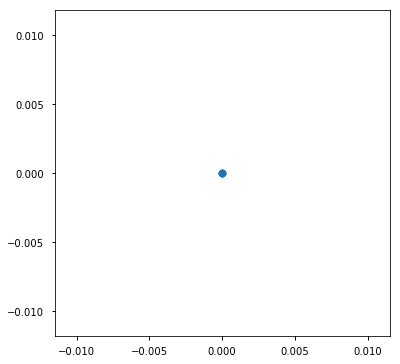

In [32]:
# Example distribution of latent layer
plt.figure(figsize=(6, 6))
plt.scatter(encoded_methyl_df.iloc[:, 5], encoded_methyl_df.iloc[:, 8])

## Decoder

In [33]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

In [34]:
# How well does the model reconstruct the input Methylation data
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df2.index,
                                        columns=methyl_df2.columns)
input_methyl_reconstruct.head(3)

,cg19242459,cg06365016,cg23548438,cg16339238,cg06160397,cg11075353,cg20785560,cg14040931,cg15233892,cg23184518,...,cg11519260,cg00691123,cg25254074,cg08904363,cg01385312,cg09251737,cg26335633,cg18940047,cg14855657,cg21722775
GSM2861662,1.0,1.0,0.000042,5.067421e-10,1.0,0.999998,3.589740e-07,1.0,1.950907e-09,1.0,...,1.0,0.001385,1.0,2.066740e-09,1.0,1.0,1.379638e-08,2.158580e-09,1.653028e-09,1.0
GSM2861663,1.0,1.0,0.000218,4.318528e-09,1.0,0.999992,1.542423e-06,1.0,1.436743e-08,1.0,...,1.0,0.005917,1.0,1.605942e-08,1.0,1.0,8.442025e-08,1.547091e-08,1.149885e-08,1.0
GSM2861664,1.0,1.0,0.000048,7.604981e-10,1.0,0.999998,4.683047e-07,1.0,2.924198e-09,1.0,...,1.0,0.001391,1.0,3.135256e-09,1.0,1.0,2.007484e-08,3.258074e-09,2.476826e-09,1.0


In [35]:
print(methyl_df2.shape)
methyl_df2.head(3)

(16, 300000)


,cg19242459,cg06365016,cg23548438,cg16339238,cg06160397,cg11075353,cg20785560,cg14040931,cg15233892,cg23184518,...,cg11519260,cg00691123,cg25254074,cg08904363,cg01385312,cg09251737,cg26335633,cg18940047,cg14855657,cg21722775
GSM2861662,0.940602,0.855804,0.344986,0.036378,0.882570,0.500409,0.302655,0.888828,0.138864,0.939979,...,0.928271,0.351497,0.757858,0.192191,0.907131,0.928538,0.113393,0.169197,0.075777,0.930340
GSM2861663,0.934186,0.958937,0.519697,0.152623,0.890004,0.020511,0.354201,0.832888,0.210407,0.905674,...,0.920533,0.496424,0.811230,0.125436,0.923287,0.861147,0.199454,0.361812,0.066014,0.892449
GSM2861664,0.933304,0.757727,0.327101,0.032106,0.849765,0.902973,0.202559,0.869846,0.100477,0.948471,...,0.957843,0.331091,0.791177,0.145568,0.920710,0.957216,0.106493,0.111420,0.060864,0.920947


In [36]:
#methylation_out_file = os.path.join('data', 'TCGA_BRCA_30kgenerated_cpg.tsv')
methylation_out_file = os.path.join('data', 'TCGA_BRCA_300kgenerated_cpg_100latent.tsv')
methyl_df2.to_csv(methylation_out_file, sep='\t')

In [37]:
#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-10.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-10.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_10K-100.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_10K-100.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_30K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_30K-1000.hdf5')

#encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-1000.hdf5')
#decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-1000.hdf5')

encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_300K-100.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_300K-100.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)